## This notebook is used for testing MTAOS communication with the AOS components: M1M3, M2, and hexapods

Step-by-step description of what we do can be found in 
Jira test case: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T???? 

test on NTS first:

* Do all the callback messages look right?
* Look at the EFD notebooks at the same time. Is everything as expected?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

Patching auth into notebook.base.handlers.IPythonHandler(notebook.base.handlers.AuthenticatedHandler) -> IPythonHandler(jupyterhub.singleuser.mixins.HubAuthenticatedHandler, notebook.base.handlers.AuthenticatedHandler)


'lsst-nts-kub06'

In [3]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd
import yaml

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

Update leap second table
current_tai uses the system TAI clock


<Figure size 432x288 with 0 Axes>

In [4]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/ts_ddsconfig/config/ospl-shmem.xml
ncsa
0


In [5]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

Read historical data in 0.00 sec


In [6]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

In [7]:
await mtcs.start_task

Read historical data in 0.12 sec
elevation DDS read queue is full (100 elements); data may be lost
cameraCableWrap DDS read queue is full (100 elements); data may be lost
Read historical data in 0.15 sec
azimuth DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 97 of 100 elements
application DDS read queue is filling: 98 of 100 elements
actuators DDS read queue is filling: 99 of 100 elements
electrical DDS read queue is filling: 73 of 100 elements
application DDS read queue is filling: 75 of 100 elements
timeAndDate DDS read queue is full (100 elements); data may be lost
powerSupplyData DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 75 of 100 elements
pidData DDS read queue is full (100 elements); data may be lost


[None, None, None, None, None, None, None, None, None, None]

mountStatus DDS read queue is full (100 elements); data may be lost
inclinometerData DDS read queue is full (100 elements); data may be lost
mountPosition DDS read queue is full (100 elements); data may be lost
imsData DDS read queue is full (100 elements); data may be lost
currentTargetStatus DDS read queue is full (100 elements); data may be lost


In [8]:
mtcs.components_attr

hardpointMonitorData DDS read queue is full (100 elements); data may be lost
hardpointActuatorData DDS read queue is full (100 elements); data may be lost
gyroData DDS read queue is full (100 elements); data may be lost
forceActuatorData DDS read queue is full (100 elements); data may be lost
accelerometerData DDS read queue is full (100 elements); data may be lost


['mtmount',
 'mtptg',
 'mtaos',
 'mtm1m3',
 'mtm2',
 'mthexapod_1',
 'mthexapod_2',
 'mtrotator',
 'mtdome',
 'mtdometrajectory']

In [9]:
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
aos = mtcs.rem.mtaos
mount = mtcs.rem.mtmount
rot = mtcs.rem.mtrotator

In [10]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage  #None
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

In [11]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [20]:
await salobj.set_summary_state(aos, salobj.State.ENABLED) #, settingsToApply='default') #leave this out!!
#two levels of defaults: csc defaults, config repo; right now csc defaults, they will move to config repo; 
#but to load defaults from config repo, we do not need to supply settingsToApply

20: Execute configure().


[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [12]:
#summit = 1 #use this for summit testing
summit = 0 #use this for NCSA

In [13]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

#### Check summary state of each CSC

In [14]:
await checkAOSSummaryStates(aos, m1m3, m2, camhex, m2hex)

starting with: MTAOS state State.ENABLED 2021-08-10 15:15:29.346543616
starting with: M1M3 state State.ENABLED 2021-07-30 23:08:23.264122880
          detailed state DetailedState.ACTIVE 2021-07-30 23:08:23.264244992
staring with: m2 state State.ENABLED 2021-07-28 17:36:48.156721664
staring with: cam hex state State.ENABLED 2021-07-28 17:36:48.499936768
          cam hex state EnabledSubstate.STATIONARY 2021-08-06 08:10:22.465788416
staring with: M2 hex state State.ENABLED 2021-07-28 17:36:48.489722368
          hex state EnabledSubstate.STATIONARY 2021-08-06 08:10:22.534036224


### Get M1M3 Ready: raise mirorr, turn on FB, clear forces

In [15]:
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

In [59]:
print('Re-enabling M1M3')
#await salobj.set_summary_state(m1m3, salobj.State.STANDBY) 
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

Re-enabling M1M3


[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [16]:
await readyM1M3(m1m3)

m1m3 inclinometer Angle =  74.99800109863281
M1M3 is raised
m1m3 z position =  0.0
Magnitude of the m1m3 force balance system 1616.3057861328125


### Get M2 Ready: turn on FB, clear forces

In [20]:
await m2.evt_heartbeat.next(flush=True, timeout=5)

In [18]:
await salobj.set_summary_state(m2, salobj.State.ENABLED) 
#await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [17]:
await readyM2(m2)

m2 inclinometer angle =  14.978584888644473
Status of the M2 force balance system True
clear any M2 activeopticForces (or any other hunman-applied forces)


### Get cam hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [22]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [24]:
await mount.cmd_moveToTarget.set_start(elevation=75, azimuth=0)

In [26]:
await rot.cmd_move.set_start(position=0)

In [29]:
#await camhex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True)

In [18]:
await readyHexaForAOS(camhex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-28 17:36:48.242355712
pivot at (0, 0, 500000) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled? True 2021-07-30 23:17:28.038541824
hexapod already at LUT position
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-08-06 08:10:22.341952256
Compensated position
     -0.82    -311.15     267.00      -0.008571   0.000000   0.000000    2021-08-06 08:10:22.342303744
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  75.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -0.8197689278882421 -311.1522845009765 266.9954574997853 -0.008570978028279296 0.0 0.0


In [46]:
await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

In [19]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [22]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply="default")

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

In [19]:
state = await camhex.evt_summaryState.aget(timeout=5)
print('staring with: cam hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
dstate = await camhex.evt_controllerState.aget(timeout=5)
print('          cam hex state', MTHexapod.EnabledSubstate(dstate.enabledSubstate), 
  pd.to_datetime(dstate.private_sndStamp, unit='s'))

staring with: cam hex state State.ENABLED 2021-07-28 17:36:48.499936768
          cam hex state EnabledSubstate.STATIONARY 2021-08-06 08:10:22.465788416


In [20]:
mount_angle = await mount.tel_elevation.next(flush=False, timeout=10.)
print("mount elevation angle", mount_angle.actualPosition)
elev = mount_angle.actualPosition

elevation python read queue is full (100 elements); data may be lost


mount elevation angle 75.0


### Get M2 hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [33]:
await m2hex.evt_heartbeat.next(flush=True, timeout=5)

In [35]:
#await m2hex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True)

In [21]:
await readyHexaForAOS(m2hex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-28 17:36:48.231204864
pivot at (0, 0, 500000) microns 
maxXY =  10500.0 microns, maxZ=  8900.0  microns
maxUV =  0.175 deg, maxW=  0.05  deg
compsensation mode enabled? True 2021-07-30 23:27:47.791414016
hexapod already at LUT position
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-08-06 08:10:22.339675648
Compensated position
     -2.74    -270.37     288.52      -0.003236   0.000000   0.000000    2021-08-06 08:10:22.339991040
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  75.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -2.7378341010400375 -270.36866857539064 288.51589440595694 -0.003236147000060546 0.0 0.0


In [23]:
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply="default")

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

In [22]:
await aos.cmd_resetCorrection.set_start()
await aos.cmd_issueCorrection.set_start() 

20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M2 correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.


### Step 1: add aberrations via OFC

In [23]:
zernikes = np.zeros(19)
zerIdx = np.arange(4, 23)
zernikes[7-4] = 1 #add 1um of z7
print(zerIdx)
print(zernikes)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
#x0 makes sure corrections double when same aberrations are added twice
config = {"xref": "x0"}  
config_yaml = yaml.safe_dump(config)

In [25]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

10: Customizing OFC parameters.
10: Overriding ofc_data parameter xref.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter xref.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


DOF event time =  2021-08-10 22:31:26.235341568
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


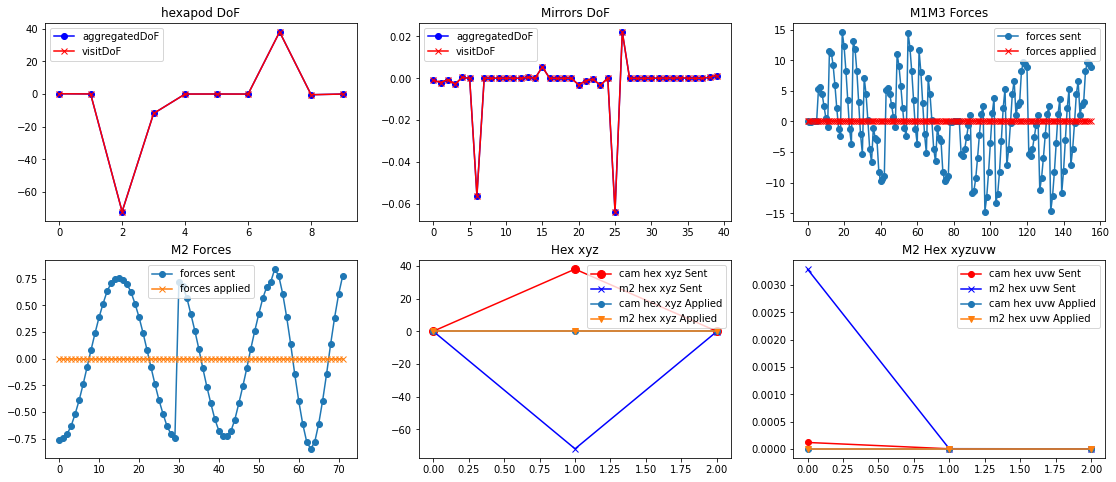

In [26]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [27]:
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.


DOF event time =  2021-08-10 22:31:26.235341568
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


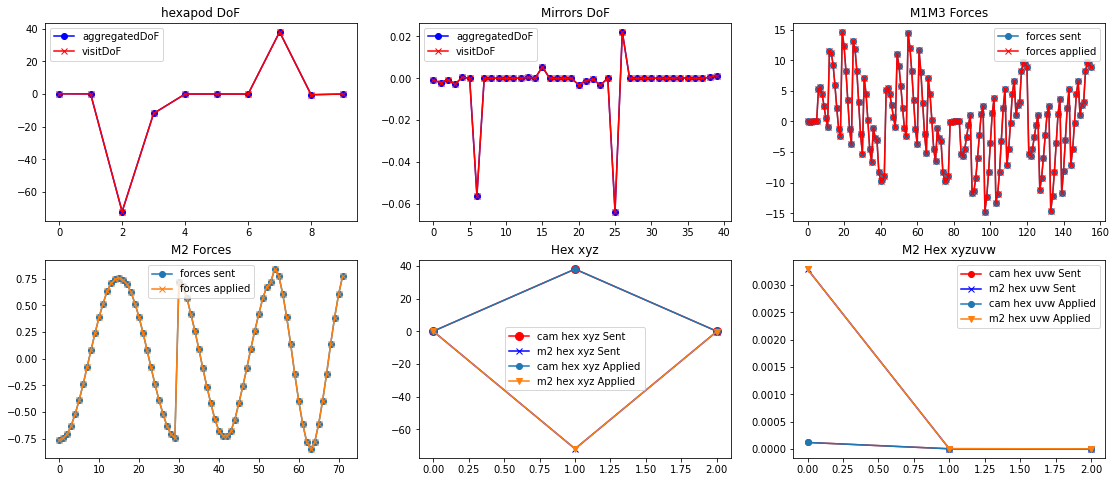

In [28]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

#### Look at telemetry to verify the changes in the DOFs

In [30]:
end = Time(datetime.now(), scale='tai')
#end = Time('2021-05-14T18:25:30', scale = 'tai')
start = end - timedelta(seconds=100)

dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.logevent_uncompensatedPosition', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


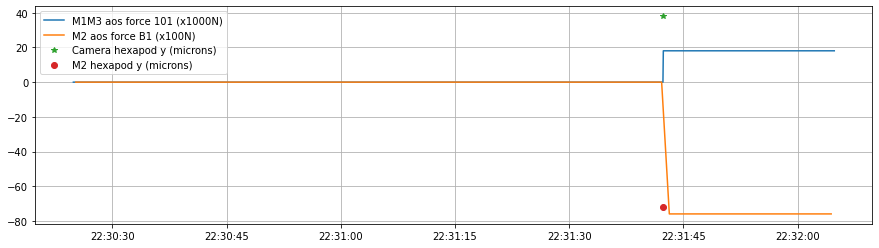

In [31]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
#plt.plot(dfm.actualPosition, '--', label='mount elevation')
plt.plot(dfm1m3.zForces0*1e3, label='M1M3 aos force 101 (x1000N)')
plt.plot(dfm2.applied0*1e2, label='M2 aos force B1 (x100N)')
plt.plot(dfh1.y, '*', label='Camera hexapod y (microns)')
plt.plot(dfh2.y, 'o', label='M2 hexapod y (microns)')
plt.grid()
plt.legend()

### Step 2: Reset the corrections

In [41]:
await aos.cmd_resetCorrection.set_start()
await aos.cmd_issueCorrection.set_start() 

20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M2 correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.


DOF event time =  2021-08-10 23:09:07.372083456
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


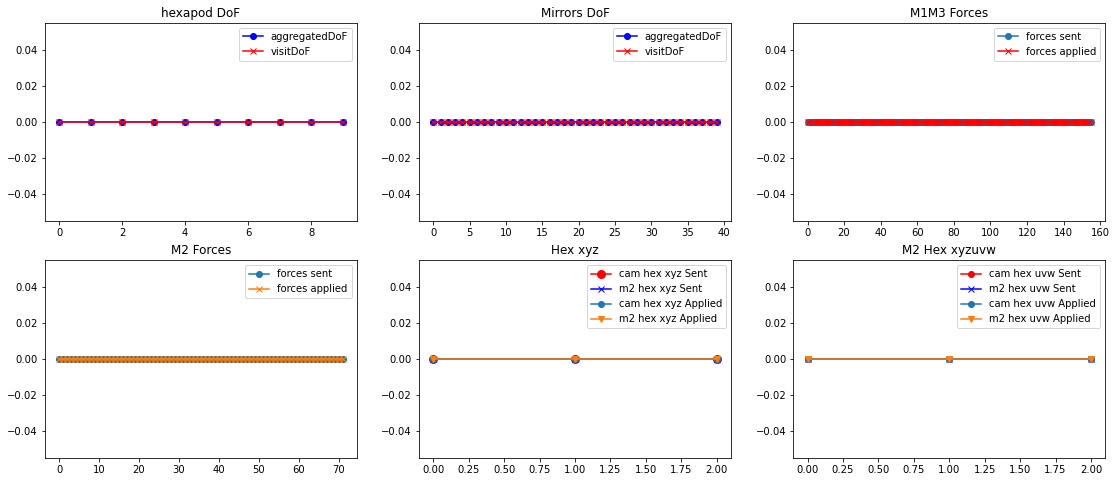

In [42]:
ofc_dict3 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

### Step 3: Double the aberration, do the corrections double? yes

In [43]:
zernikes[7-4] = 2 # z7 = 2um

In [44]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [45]:
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
10: Issue the M2 correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.


DOF event time =  2021-08-10 23:09:45.381036032
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


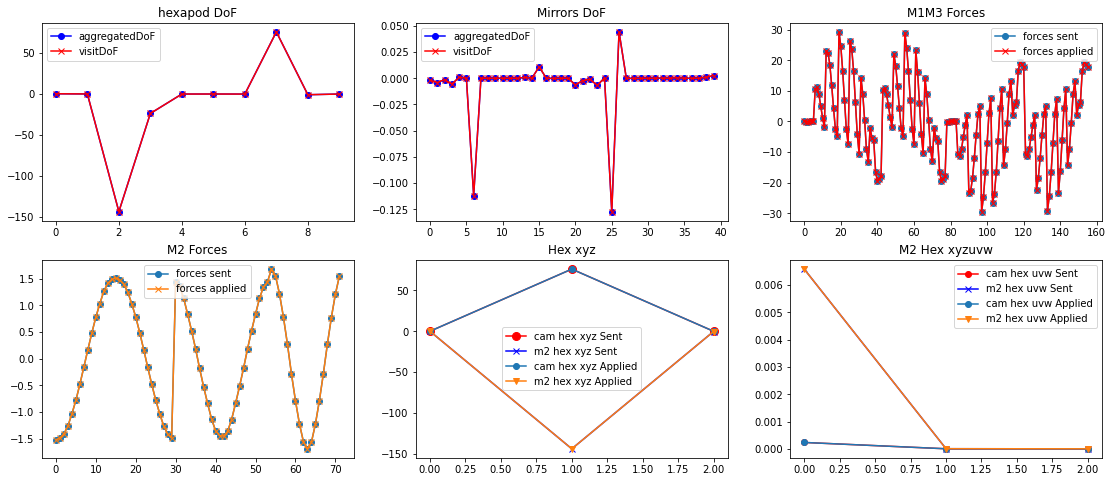

In [46]:
ofc_dict4 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [47]:
ofc_dict4['camhexC'][:5]/ofc_dict['camhexC'][:5]

array([2., 2., 2., 2., 2.])

In [48]:
ofc_dict4['m2hexC'][:5]/ofc_dict['m2hexC'][:5]

array([2., 2., 2., 2., 2.])

### Close up

In [ ]:
#if we started with enabled state, we need to put it back
await salobj.set_summary_state(m1m3, salobj.State.ENABLED,  settingsToApply='Default')

In [144]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE)

[<State.STANDBY: 5>, <State.OFFLINE: 4>]

In [143]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [131]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

forceActuatorForceWarning DDS read queue is full (100 elements); data may be lost


In [129]:
await salobj.set_summary_state(aos, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [142]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-05-14 19:47:36.387881984
m1m3 state DetailedState.PARKED 2021-05-14 19:49:20.622984960


### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)